<a href="https://colab.research.google.com/github/LimelightVision/notebooks/blob/main/limelight_tfrecord_unpacker_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![UnpackerNotebookLogo](https://ik.imagekit.io/llimi/docs/UnpackerNotebookLogo.png?updatedAt=1739507557283)

In [2]:
import gdown
import os
from IPython.display import display
from ipywidgets import Text, Button, VBox

def process_dataset():
    link_input = Text(
        value='',
        placeholder='Paste your Google Drive share link here',
        description='Drive Link:',
        style={'description_width': 'initial'},
        layout={'width': '50%'}
    )

    def on_click(b):
        try:
            print("Downloading dataset...")
            url = link_input.value

            if 'drive.google.com/file/d/' in url:
                file_id = url.split('/file/d/')[1].split('/')[0]
                url = f'https://drive.google.com/uc?id={file_id}'

            output = '/content/dataset.zip'
            gdown.download(url, output, fuzzy=True)
            print("Download complete!")

        except Exception as e:
            print(f"Error: {str(e)}")

    process_button = Button(description='Process Dataset', button_style='primary')
    process_button.on_click(on_click)
    display(VBox([link_input, process_button]))

# Install gdown if not already installed
!pip install -q gdown --upgrade

# Execute
process_dataset()

Downloading...
From (original): https://drive.google.com/uc?id=1KoBcbGBzyLf63g82P1W8s8jooizyCQXo
From (redirected): https://drive.google.com/uc?id=1KoBcbGBzyLf63g82P1W8s8jooizyCQXo&confirm=t&uuid=76104c69-0391-4098-ae50-a79beba71dc8
To: /content/dataset.zip
100%|██████████| 200M/200M [00:03<00:00, 58.4MB/s]

Download complete!


In [3]:
datasetPath = '/content/dataset.zip'
print(datasetPath)
!unzip $datasetPath


/content/dataset.zip
Archive:  /content/dataset.zip
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/coral-algae.tfrecord  
  inflating: test/coral-algae_label_map.pbtxt  
   creating: train/
 extracting: train/coral-algae.tfrecord  
  inflating: train/coral-algae_label_map.pbtxt  
   creating: valid/
 extracting: valid/coral-algae.tfrecord  
  inflating: valid/coral-algae_label_map.pbtxt  


Train Record File: /content/train/coral-algae.tfrecord
Validation Record File: /content/valid/coral-algae.tfrecord
Label Map File: /content/train/coral-algae_label_map.pbtxt


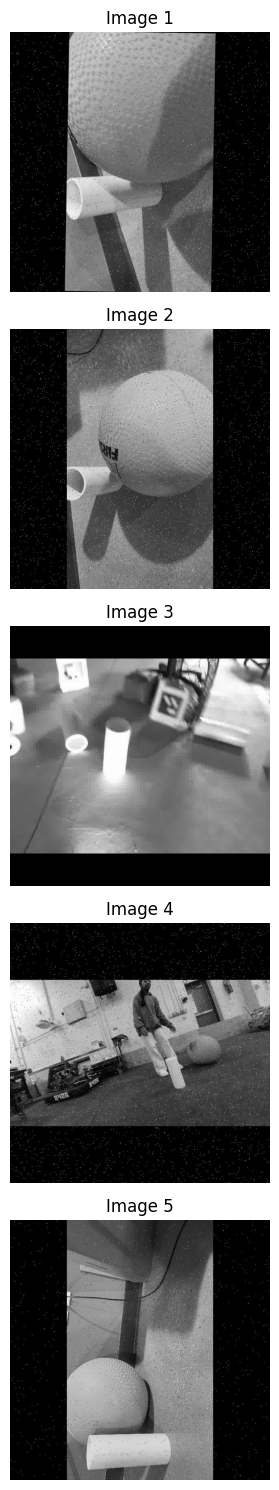

In [7]:
import os
import fnmatch

def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename

def set_tfrecord_variables(directory):
    train_record_fname = ''
    val_record_fname = ''
    label_map_pbtxt_fname = ''

    for tfrecord_file in find_files(directory, '*.tfrecord'):
        if '/train/' in tfrecord_file:
            train_record_fname = tfrecord_file
        elif '/valid/' in tfrecord_file:
            val_record_fname = tfrecord_file
        elif '/test/' in tfrecord_file:
            pass

    for label_map_file in find_files(directory, '*_label_map.pbtxt'):
        label_map_pbtxt_fname = label_map_file  # Assuming one common label map file

    return train_record_fname, val_record_fname, label_map_pbtxt_fname


train_record_fname, val_record_fname, label_map_pbtxt_fname = set_tfrecord_variables('/content')


print("Train Record File:", train_record_fname)
print("Validation Record File:", val_record_fname)
print("Label Map File:", label_map_pbtxt_fname)


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def parse_tfrecord(example_proto):
    """Parse the input tf.Example proto using the dictionary feature_description."""
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def decode_image(parsed_features):
    """Decode the image from parsed features."""
    image = tf.io.decode_image(parsed_features['image/encoded'])
    return image

def display_images(tfrecord_path, num_images=5):
    """Display images from a TFRecord file."""
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord)

    fig = plt.figure(figsize=(15, 3*num_images))

    for i, parsed_features in enumerate(dataset.take(num_images)):
        image = decode_image(parsed_features)

        plt.subplot(num_images, 1, i+1)
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()


def display_single_image(tfrecord_path, image_index=0):
    """Display a single image from a TFRecord file."""
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord)

    for i, parsed_features in enumerate(dataset):
        if i == image_index:
            image = decode_image(parsed_features)
            plt.figure(figsize=(10, 10))
            plt.imshow(image.numpy())
            plt.axis('off')
            plt.show()
            break


tfrecord_path = train_record_fname
display_images(tfrecord_path, num_images=5)
# Example usage for single image:
# display_single_image(tfrecord_path, image_index=0)